In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scipy.stats as stats
import seaborn

# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Testing with Synthetic Data

In [182]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = random(4,52, density = 0.08).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [183]:
W,H = gen_data()
X = np.dot(W,H)

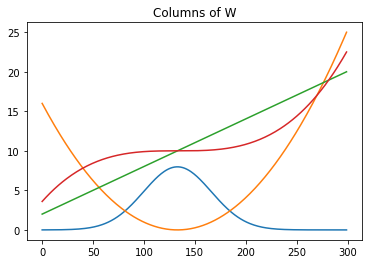

In [184]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

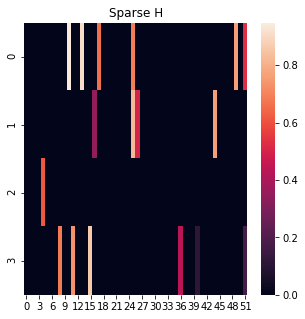

In [185]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [186]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.8613770298127919


In [187]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.21078519104020454


### Comparing SparseNMF with Sklearn NMF

In [188]:
model = SparseNMF(X, 4, iterations = 500, sH = h_sparse)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

Text(0.5, 1.0, 'Original columns of W')

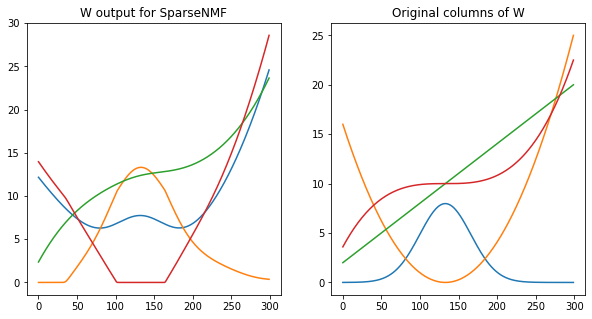

In [189]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(spW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for SparseNMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

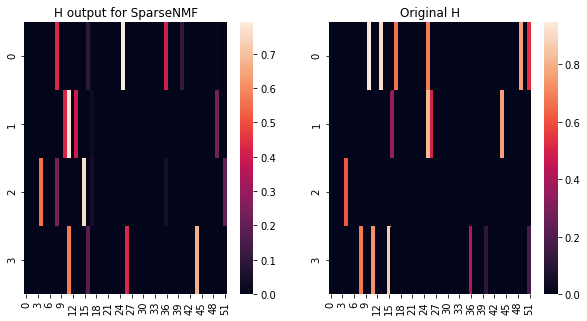

In [190]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(spH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for SparseNMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [191]:
# ERRors
print("SparseNMF error on W:", np.linalg.norm(W - spW/1.7))
print("SparseNMF error on H:", np.linalg.norm(H - spH))
print("SparseNMF error on X:", np.linalg.norm(X - np.dot(spW, spH)))

SparseNMF error on W: 246.54005625216757
SparseNMF error on H: 2.9730876737942578
SparseNMF error on X: 72.87461073798633


In [192]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

Text(0.5, 1.0, 'Original columns of W')

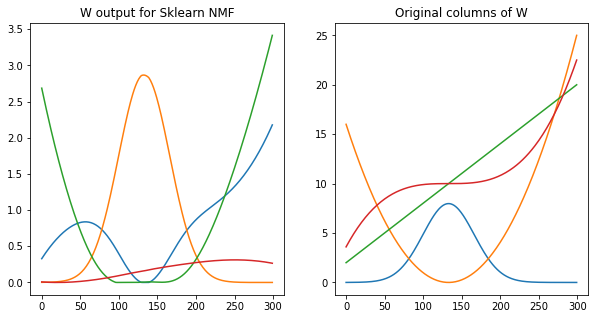

In [193]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(sciW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for Sklearn NMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

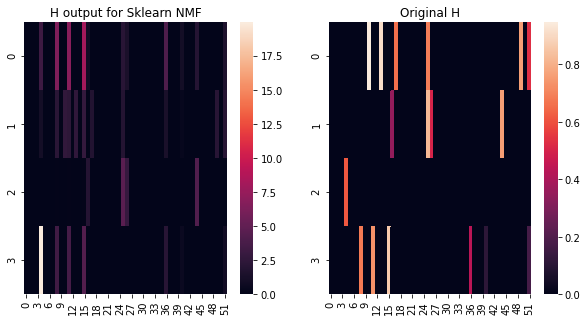

In [194]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(sciH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for Sklearn NMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [195]:
print("Scipy error on W:", np.linalg.norm(W - sciW))
print("Scipy error on H:", np.linalg.norm(H - sciH))
print("Scipy error on X:", np.linalg.norm(X - np.dot(sciW, sciH)))

Scipy error on W: 330.6507348976221
Scipy error on H: 26.96813625567328
Scipy error on X: 0.5211931113102174


# Diffusion NMF

### Random Laplacian

In [253]:
# Making a synthetic laplacian and corresponding diffusion kernel:
locs = X.shape[1]
lapl = np.zeros((locs,locs))

In [254]:
for i in range(lapl.shape[0]):
    for j in range(lapl.shape[1]):
        if i == j:
            break
        else:
            lapl[i,j] = -1 * np.random.choice([0,1], p = [0.8,0.2])
            lapl[j,i] = lapl[i,j]

In [258]:
for i in range(lapl.shape[0]):
    lapl[i,i] = -1 * lapl[i].sum()

In [259]:
L = lapl
I = np.identity(locs)

In [262]:
def diffn_plot(w, h, lap, beta_vals, sparseness = None):
    # plot the diffusion NMF results over a range of beta values
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, sparseV = sparseness, sparseX = None, iterations = 1000, tol = 1e-200)
            differ.solver()
            diffX = pd.DataFrame(differ.X)
            diffV = pd.DataFrame(differ.V)

            fix, ax = plt.subplots(1, 2, figsize = (10,5))
            for col in spW:
                ax[0].plot(diffX.loc[:,col])
                ax[1].plot(W.loc[:,col])

                ax[0].set_title("X output for Diffusion NMF for beta = " + str(beta))
                ax[1].set_title("Original columns of W")
            plt.show()

            fig, ax = plt.subplots(2, 1, figsize = (5,10))
            seaborn.heatmap(diffV, square = False, cbar = True, ax = ax[0])
            ax[0].set_title("V output for Diffusion NMF")
            seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
            ax[1].set_title("Original H")
            plt.show()

            print("Diffusion X error on W:", np.linalg.norm(W - diffX))
            print("Diffusion V error on H:", np.linalg.norm(H - diffV))
            print("Diffusion error on D:", np.linalg.norm(D - np.dot(diffX, np.dot(diffV, K))))
            print()

K Condition Number : 20.70270716894065


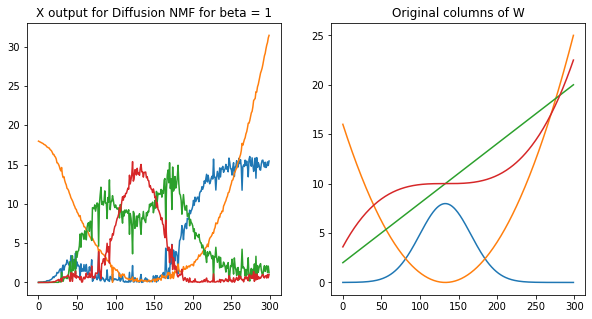

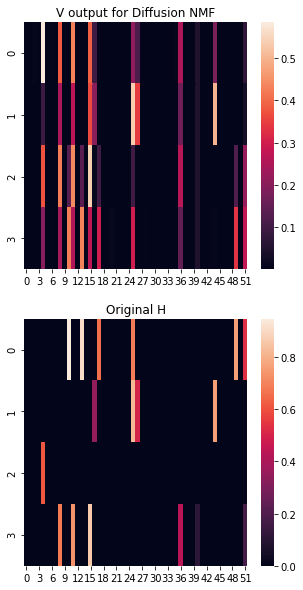

Diffusion X error on W: 279.8587053324035
Diffusion V error on H: 2.665927664436376
Diffusion error on D: 3.0603913543942576

K Condition Number : 60.108121506821895


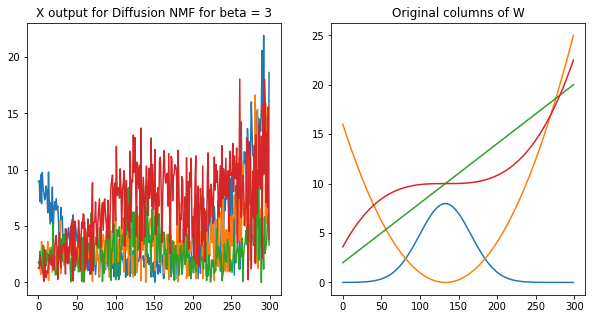

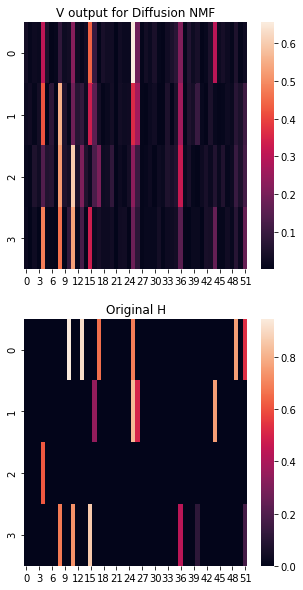

Diffusion X error on W: 251.71996241143623
Diffusion V error on H: 2.6517041388445217
Diffusion error on D: 5.849695126154765

K Condition Number : 99.51353584470297


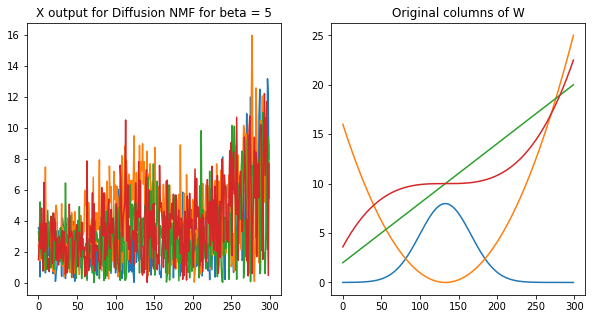

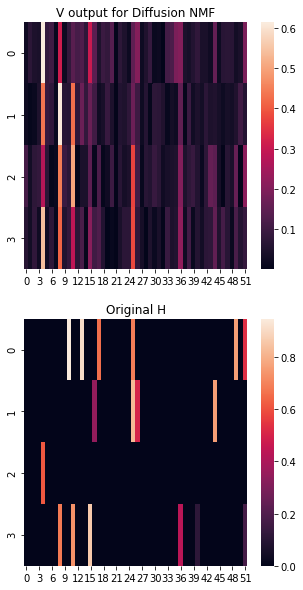

Diffusion X error on W: 255.48012022112644
Diffusion V error on H: 2.849605431308407
Diffusion error on D: 4.775850964790272

K Condition Number : 198.02707168940637


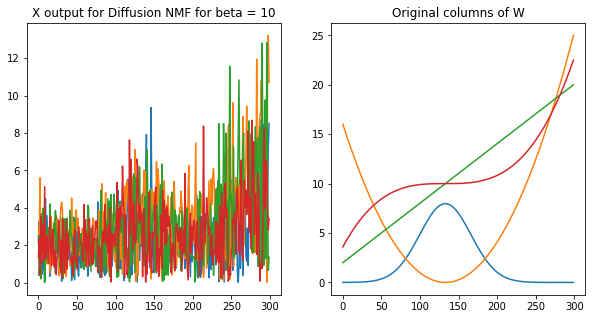

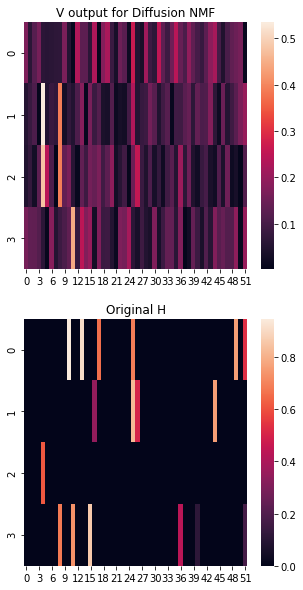

Diffusion X error on W: 263.39307098706564
Diffusion V error on H: 2.822479457505173
Diffusion error on D: 3.456399321153785



In [263]:
diffn_plot(W,H,L, [1,3,10])

### State adjacency Laplacian

In [243]:
state_L = pd.read_csv(os.path.join(par, "state_laplacian.csv"), index_col = 0).to_numpy()

K Condition Number : 10.95709432694549


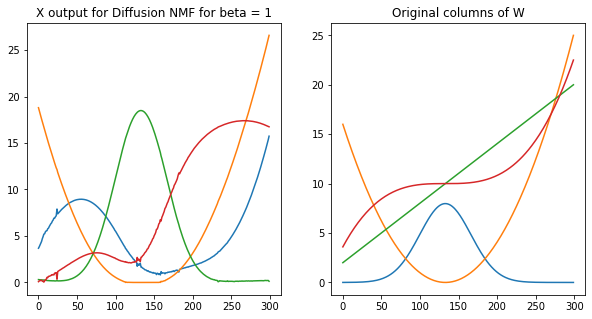

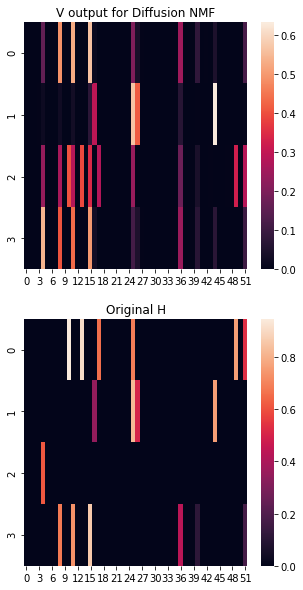

Diffusion X error on W: 230.1480837019745
Diffusion V error on H: 2.435059437262028
Diffusion error on D: 1.2834105118674615

K Condition Number : 30.871282980836465


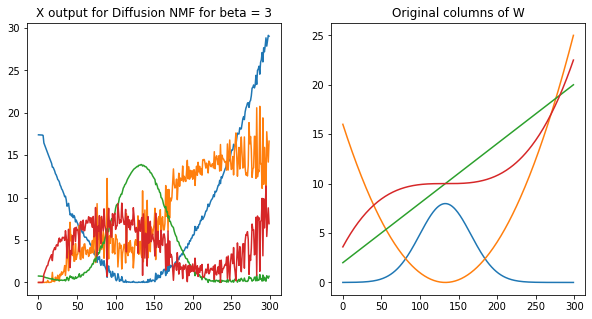

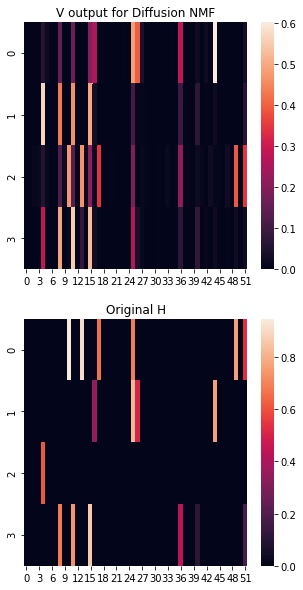

Diffusion X error on W: 328.19855364217216
Diffusion V error on H: 2.82723730987688
Diffusion error on D: 3.5527033805647403

K Condition Number : 100.57094326945528


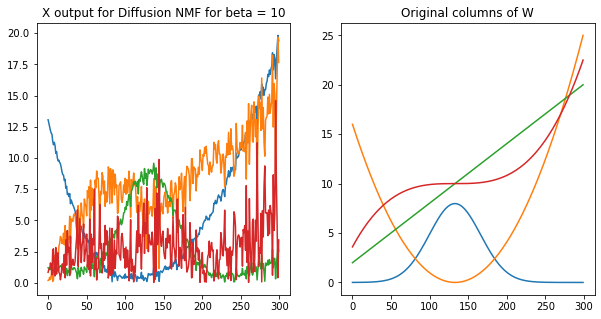

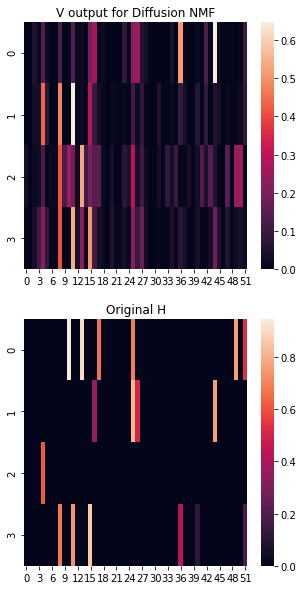

Diffusion X error on W: 292.5537486376702
Diffusion V error on H: 2.8595643666107557
Diffusion error on D: 3.881681739129165



In [244]:
diffn_plot(W,H,state_L, [1,3,10])